Running the dynamic NN models (64-64) for respiratory and non-respiratory visits only.

In [1]:
%run ../MLHCExperiment-Common-Val17Test18.ipynb

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
all_visits = read_data()
all_visits = all_visits.where(all_visits["AdjCount"] > 0).dropna()

In [3]:
epochs = 1000
patience = 10
trials = 5

In [4]:
def run_dynamic_nn(name, features, label, epochs, patience, trials):
    print(name)
    X = all_visits[features]
    y = all_visits[label]

    mses = list()
    val_mses = list()

    early_stop = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error',
                                               patience=patience, restore_best_weights=True)
    
    X_train, y_train, X_val, y_val, X_test, y_test = split_for_baseline_and_nn(X, y)
    
    for j in range(trials):
        print("Trial %d" % (j + 1))
        start = time.time()
        predictions = list()

        mod = build_nn_model_generic(X_train, 64, 64)
        history = mod.fit(X_train, y_train.values, epochs=epochs, shuffle=False,
                            validation_data=[X_val, y_val.values], verbose=0,
                            callbacks=[PrintDot(), early_stop])
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch 
        plot_history(hist)

        val_mses.append(min(history.history["val_mean_squared_error"]))
        
        # serialize weights to HDF5
        model_name = name + "-Trial" + str(j) + "-" + str(time.time()) + ".h5"
        mod.save_weights(model_name)

        y_pred = mod.predict(X_test, batch_size=1)
        mses.append(mean_squared_error(y_pred, y_test))
        end = time.time()
        print("Trial completed in %.2f s" % (end - start))
        print("Average MSE so far: %.3f (%.3f)" % (np.mean(mses), np.std(mses)))
    
    print("On the test set:")
    print_mse_metrics(mses)
    print("On the validation set:")
    print_mse_metrics(val_mses)
    fig, ax = plt.subplots(figsize=(15,7))
    ax.set(title=name, xlabel='Date', ylabel='Sick Visits Per FTE')
    all_visits.loc[TEST_START:, label].plot(ax=ax, color='gray', style='.', label='actual sick visits/fte')
    plt.scatter(all_visits.loc[TEST_START:].index, y_pred, color='r',label='predicted sick visits/fte')
    plt.legend()
    return val_mses, mses, y_pred

Dynamic-NN-RespVisits-64-64
Trial 1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
...Trial completed in 92.66 s
Average MSE so far: 0.483 (0.000)
Trial 2

....................................................................................................
...............................................................................Trial completed in 56.56 s
Average MSE so far: 0.489 (0.006)
Trial 3

....................................................................................................
....................................................................

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Trial completed in 41.61 s
Average MSE so far: 0.754 (0.011)
On the test set:
MSE and RMSE over 10 trials with standard deviation in parentheses
Average MSE: 0.754 (0.011)
Average RMSE: 0.868 (0.006)
On the validation set:
MSE and RMSE over 10 trials with standard deviation in parentheses
Average MSE: 0.454 (0.005)
Average RMSE: 0.674 (0.004)


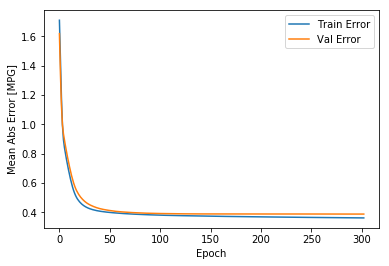

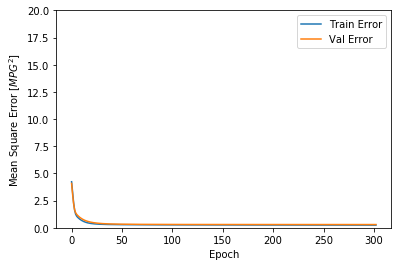

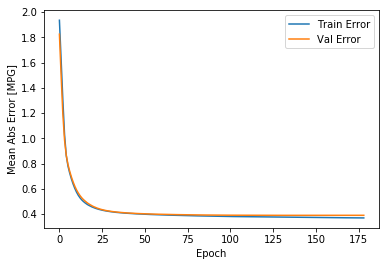

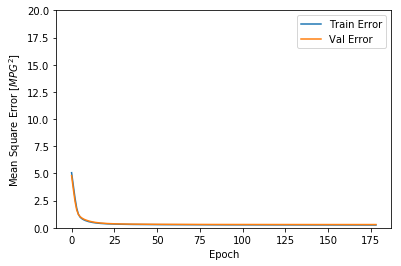

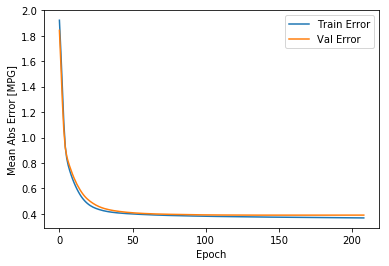

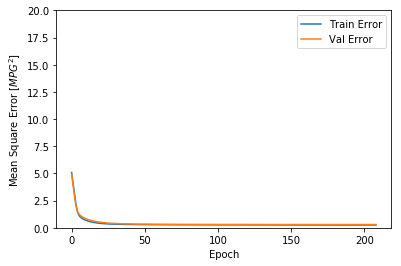

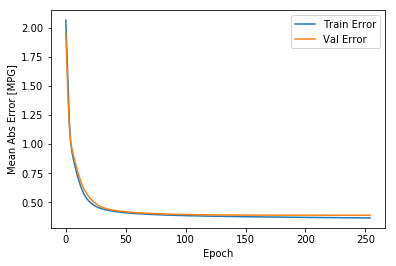

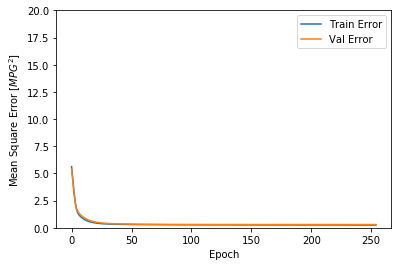

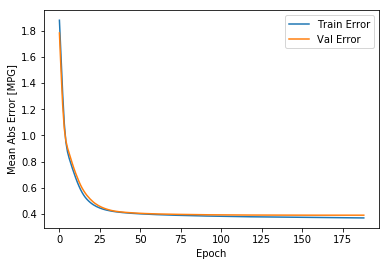

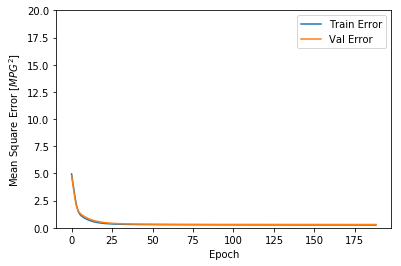

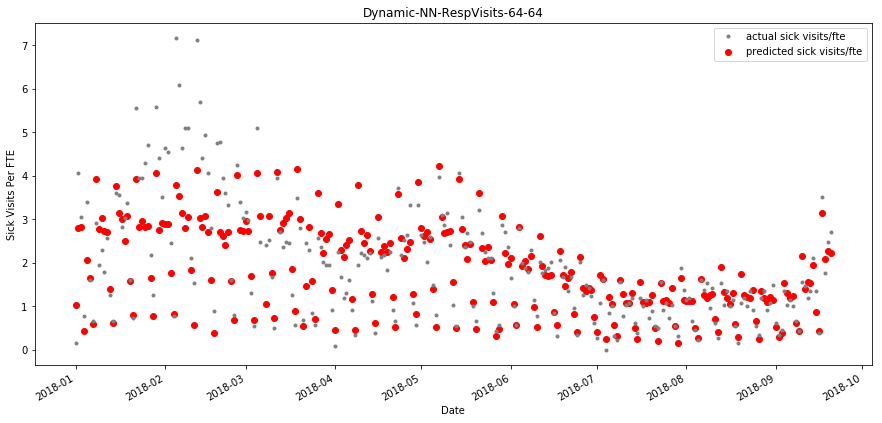

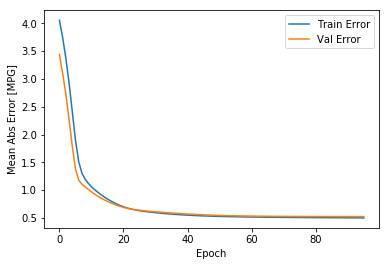

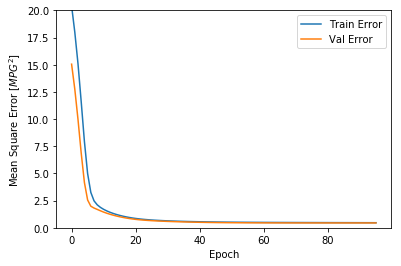

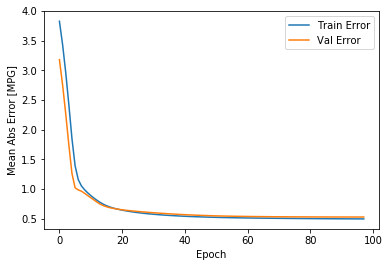

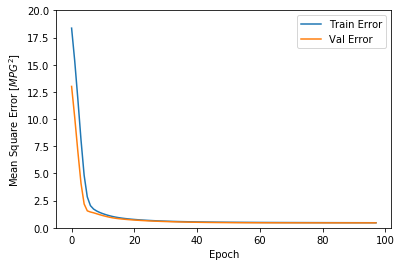

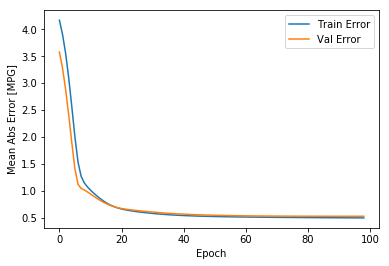

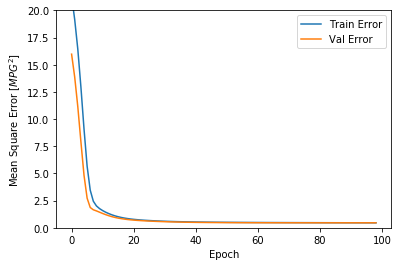

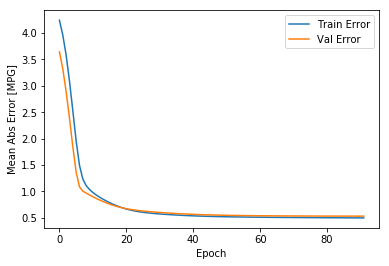

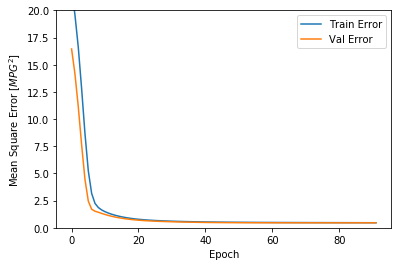

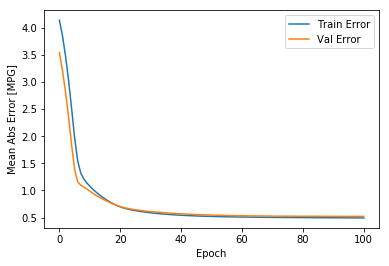

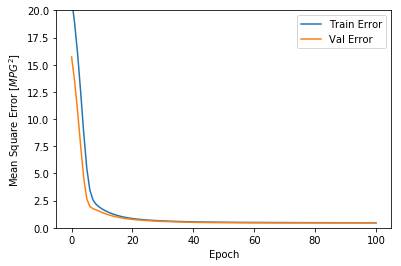

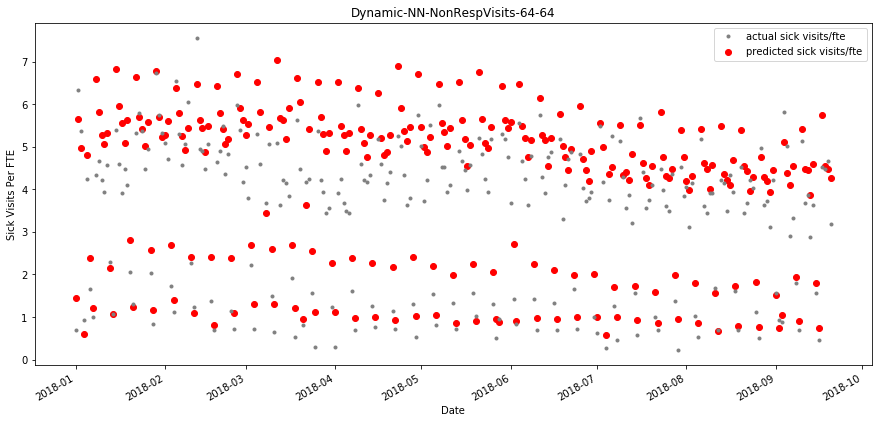

In [5]:
_, _, _ = run_dynamic_nn("Dynamic-NN-RespVisits-64-64", BASE_FEATURES, ICD8_LABEL, epochs, patience, trials)

_, _, _ = run_dynamic_nn("Dynamic-NN-NonRespVisits-64-64", BASE_FEATURES, ICD8OPP_LABEL, epochs, patience, trials)